In [90]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, DirectTimeSeriesRegressionForecaster, DirectTabularRegressionForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sklearn.exceptions import ConvergenceWarning
import requests
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.compose import YfromX
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.compose import ColumnwiseTransformer
from sktime.forecasting.compose import ForecastingPipeline

import warnings
warnings.filterwarnings('ignore')

Getting predictions from internal model

In [91]:
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import BaggingForecaster
from sktime.datasets import load_airline
y = load_airline()
forecaster = BaggingForecaster(
    STLBootstrapTransformer(sp=12), NaiveForecaster(sp=12)
)  
forecaster.fit(y)  

forecaster.predict([1,2,3])  
forecaster.predict_interval([1,2,3])

Coverage            
                   0.9            
                 lower       upper
time_index                        
1961-01     399.117066  424.727538
1961-02     378.878278  397.673766
1961-03     420.509584  438.054012

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

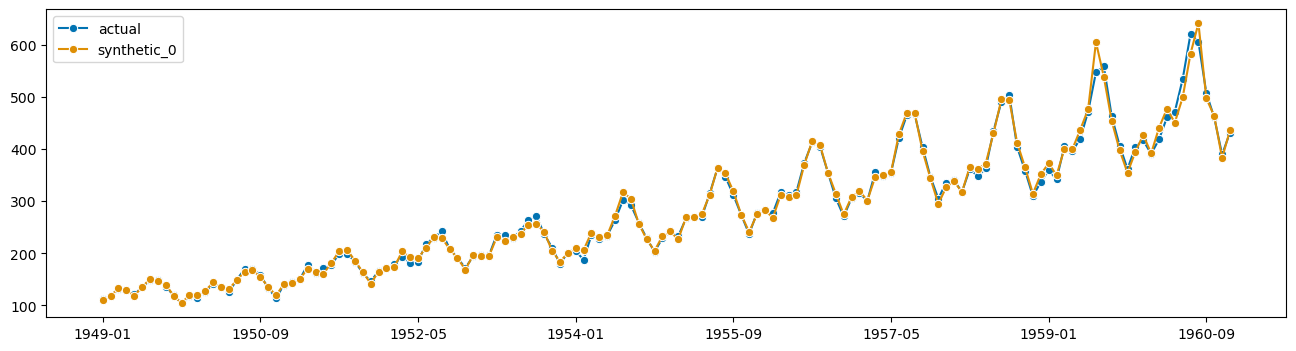

In [92]:
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series  

transformer = STLBootstrapTransformer(1)  
y_hat = transformer.fit_transform(y)  
series_list = []  
names = []  
for group, series in y_hat.groupby(level=[0], as_index=False):
    series.index = series.index.droplevel(0)
    series_list.append(series)
    names.append(group)  
plot_series(*series_list, labels=names) 

In [93]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, DirectTimeSeriesRegressionForecaster, DirectTabularRegressionForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sklearn.exceptions import ConvergenceWarning
import requests
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.compose import YfromX
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.compose import ColumnwiseTransformer
from sktime.forecasting.compose import ForecastingPipeline

import warnings
warnings.filterwarnings('ignore')
price_old_df = pd.read_csv('https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/supply_load_price.csv', parse_dates=['Date (MST)'], index_col='Date (MST)')
price_old_df = price_old_df.asfreq('H')
price_old_df = price_old_df.sort_values(by='Date (MST)')
price_old_df = price_old_df['2022-12':]
price_df = price_old_df['price']

In [94]:
y = price_df
selected_cols = ['ail']
X = price_old_df[selected_cols]

In [95]:
test_size = 48
forcast_len = 12

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=test_size+forcast_len)

fh = ForecastingHorizon(np.arange(1, forcast_len+1))

In [115]:
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.transformations.bootstrap import SplitterBootstrapTransformer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import BaggingForecaster
from sktime.datasets import load_airline
import my_bagging
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,
)

forecaster = my_bagging.BaggingForecaster(
    STLBootstrapTransformer(sp=24, n_series=200),
    make_reduction(
        RandomForestRegressor(n_estimators=1, n_jobs=-1),
        window_length=1,
        strategy="direct",
    )
)

# set frequnce of the df
y_train = y_train.asfreq('H')
y_test = y_test.asfreq('H')
X_train = X_train.asfreq('H')
X_test = X_test.asfreq('H')

In [116]:
forecaster.fit(y_train, X_train, fh=[1,2])

BaggingForecaster(bootstrap_transformer=STLBootstrapTransformer(n_series=200,
                                                                sp=24),
                  forecaster=DirectTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=1, n_jobs=-1),
                                                               window_length=1))

In [117]:
forecaster.predict([1,2], X_train.head(1))

time_index
2023-03-29 11:00:00    58.432147
2023-03-29 12:00:00    71.137150
Name: price, dtype: float64

In [118]:
forecaster.predict_interval([1,2], X_train.head(1))

Coverage            
                           0.9            
                         lower       upper
time_index                                
2023-03-29 11:00:00  22.619430  131.736272
2023-03-29 12:00:00  22.941346  166.346880

In [ ]:
f_d = make_reduction(
        RandomForestRegressor(n_estimators=1, n_jobs=-1),
        window_length=3,
        strategy="direct"
    )

f_d.fit(y_train, X_train, fh=fh)
f_d.predict(fh, X_train.head(1))

2023-03-29 11:00:00     51.12
2023-03-29 12:00:00     50.69
2023-03-29 13:00:00     47.38
2023-03-29 14:00:00     49.14
2023-03-29 15:00:00     50.69
2023-03-29 16:00:00     48.51
2023-03-29 17:00:00     46.55
2023-03-29 18:00:00     65.13
2023-03-29 19:00:00    228.28
2023-03-29 20:00:00    165.70
2023-03-29 21:00:00    160.12
2023-03-29 22:00:00     46.93
Freq: H, Name: price, dtype: float64

In [2]:
from sktime.forecasting.stream import UpdateRefitsEvery